<a href="https://colab.research.google.com/github/Noor-Z1/PAMAP2-DataAnalysis-ML/blob/main/Clustering/Subject_Clustering_PAMAP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNG 514 - Term Project**

### Notebook # 5

### Author: Noor Ul Zain


In this notebook, we try to cluster the 8 subjects based on different accelerometers/features we have in the dataset to visually compare which subjects are more closer to each other

In [ ]:
# mounting drive for loading the dataset files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install plotly

In [ ]:
# import the necessary libraries

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib as plt

DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values


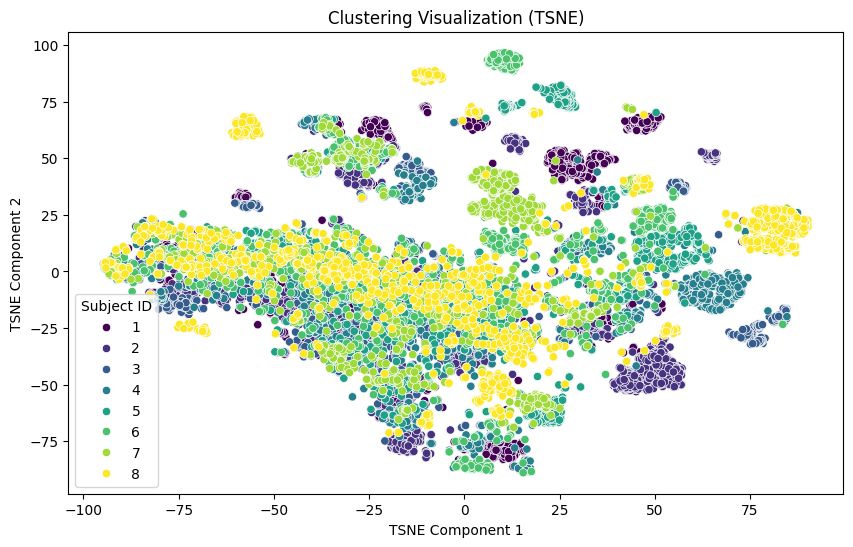

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

class PreProcessor:
    def __init__(self):
        self.dataFrame = pd.DataFrame()

    def initializeDataFrame(self, filepaths):
        colNames = ["timestamp", "activityID", "heartrate"]

        IMUhand = ['handTemperature',
                   'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
                   'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
                   'handGyro1', 'handGyro2', 'handGyro3',
                   'handMagne1', 'handMagne2', 'handMagne3',
                   'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

        IMUchest = ['chestTemperature',
                    'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
                    'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
                    'chestGyro1', 'chestGyro2', 'chestGyro3',
                    'chestMagne1', 'chestMagne2', 'chestMagne3',
                    'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

        IMUankle = ['ankleTemperature',
                    'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
                    'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
                    'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
                    'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
                    'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

        columns = colNames + IMUhand + IMUchest + IMUankle  # All columns in one list

        procData = pd.read_table(filepaths, header=None, sep='\s+')
        procData.columns = columns
        subject_id = int(os.path.basename(filepaths).split('.')[0][-1])  # Extract subject ID from file name
        procData['subject_id'] = subject_id
        self.dataFrame = self.dataFrame._append(procData, ignore_index=True)
        self.dataFrame.reset_index(drop=True, inplace=True)

    def dataCleaning(self):
        self.dataFrame = self.dataFrame.drop(
            ['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
             'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
             'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 'chestAcc6_1', 'chestAcc6_2',
             'chestAcc6_3', 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3'], axis=1)

        self.dataFrame = self.dataFrame.drop(self.dataFrame[self.dataFrame.activityID == 0].index)
        self.dataFrame = self.dataFrame.apply(pd.to_numeric, errors='ignore')
        self.dataFrame = self.dataFrame.interpolate()

    def applyPreProcessing(self):
        self.dataFrame.reset_index(drop=True, inplace=True)
        self.dataFrame.loc[:3, "heartrate"] = 100

        checkForNan = self.dataFrame.isnull().values.any()
        if checkForNan:
            print("DataFrame still contains some NAN values")

    def getSubjectDf(self, subject_id):
        return self.dataFrame[self.dataFrame['subject_id'] == subject_id]

    def getCommonLabels(self):
        """Return labels that are present in all subjects."""
        common_labels = set(self.dataFrame[self.dataFrame['subject_id'] == self.dataFrame['subject_id'].unique()[0]]['activityID'].unique())
        for subject_id in self.dataFrame['subject_id'].unique()[1:]:
            subject_labels = set(self.dataFrame[self.dataFrame['subject_id'] == subject_id]['activityID'].unique())
            common_labels = common_labels.intersection(subject_labels)
        return common_labels

    def filterCommonLabels(self):
        """Filter the data to include only common labels across all subjects."""
        common_labels = self.getCommonLabels()
        self.dataFrame = self.dataFrame[self.dataFrame['activityID'].isin(common_labels)]


class FeatureExtraction1:
    def __init__(self, subjectDf, subjectID):
        self.dataFrame = subjectDf
        self.subjectID = subjectID

    @staticmethod
    def compute_time_domain_features(data, isheartrate=False):
        mean = np.mean(data)
        std_dev = np.std(data)

        if not isheartrate:
            skewness = skew(data, nan_policy='omit')
            kurt = kurtosis(data, nan_policy='omit')
            return mean, std_dev, skewness, kurt
        else:
            return mean, std_dev

    @staticmethod
    def compute_frequency_domain_features(data, fs):
        f, Pxx = welch(data, fs=fs, nperseg=len(data))
        entropy_power = entropy(Pxx)
        peak_power_freq = f[np.argmax(Pxx)]
        return entropy_power, peak_power_freq

    @staticmethod
    def compute_signal_magnitude_area(data):
        return np.sum(np.abs(data))


    def sliding_window_feature_extraction(self, window_size=150, overlap=0, fs=100):
        acceleration_columns = ['chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
                                'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3']

        heart_rate_col = ['heartrate']
        combined_columns = acceleration_columns

        all_features = []
        all_labels = []

        stride = int(window_size * (1 - overlap))

        for start in range(0, len(self.dataFrame) - window_size + 1, stride):
            window_data_time = self.dataFrame.loc[start:start + window_size - 1, combined_columns + heart_rate_col]
            labels = self.dataFrame.loc[start:start + window_size - 1, 'activityID']

            # Ensure the window contains only one activity
            if labels.nunique() == 1:
                label = labels.iloc[0]

                # Extract time-domain features
                time_domain_features = []
                for column in combined_columns:
                    time_domain_features.extend(self.compute_time_domain_features(window_data_time[column]))
                for column in heart_rate_col:
                    time_domain_features.extend(self.compute_time_domain_features(window_data_time[column], True))

                # Extract frequency-domain features
                freq_domain_features = []
                for column in combined_columns:
                    freq_domain_features.extend(self.compute_frequency_domain_features(window_data_time[column], fs))

                # Signal magnitude area
                sma = [self.compute_signal_magnitude_area(window_data_time[column]) for column in combined_columns]

                # Combine all features
                features = np.concatenate([time_domain_features, freq_domain_features, sma])
                all_features.append(features)
                all_labels.append(label)

        return np.array(all_features), np.array(all_labels)

    def applyFeatureExtraction(self, window_size, overlap, fs):
        features, labels = self.sliding_window_feature_extraction(window_size=window_size, overlap=overlap, fs=fs)
        return features, labels


def visualize_clusters(features, subject_ids):
    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=subject_ids, palette='viridis', legend='full')
    plt.title('Clustering Visualization (TSNE)')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Subject ID')
    plt.show()


# Combine Features from All Subjects and Perform Clustering
def combine_and_cluster(file_paths):
    all_subject_features = []
    all_subject_ids = []

    for f in file_paths:
        processor = PreProcessor()
        processor.initializeDataFrame(f)
        processor.dataCleaning()
        processor.applyPreProcessing()
        processor.filterCommonLabels()

        subject_id = int(os.path.basename(f).split('.')[0][-1])

        feature_extractor = FeatureExtraction1(processor.dataFrame, subject_id)
        features, _ = feature_extractor.applyFeatureExtraction(window_size=150, overlap=0, fs=100)

        if len(features) > 0:
            all_subject_features.append(features)
            all_subject_ids.extend([subject_id] * len(features))
        else:
            print(f"No features found for subject ID: {subject_id}")

    if len(all_subject_features) == 0:
        raise ValueError("No features found for any subject.")

    # Concatenate all subject features into a single 2D array
    all_subject_features = np.vstack(all_subject_features)

    # Combine all subject features into a DataFrame
    feature_df = pd.DataFrame(all_subject_features)

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df)

    # # Apply DBSCAN clustering
    # dbscan = DBSCAN(eps=0.5, min_samples=5)
    # cluster_labels = dbscan.fit_predict(scaled_features)

    # # Visualize Clusters
    # visualize_clusters(scaled_features, all_subject_ids)

    feature_df['subject_id'] = all_subject_ids

    return feature_df, dbscan


# Example usage
file_paths = [
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject101.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject102.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject103.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject104.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject105.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject106.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject107.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject108.dat',
]

feature_df, dbscan = combine_and_cluster(file_paths)

In [ ]:
feature_df

0         1         2         3         4         5         6  \
0      0.087191  0.328334 -1.543974  1.745940  9.676431  0.110391  0.800733   
1     -1.790622  0.520457  0.884479 -0.434731  9.558212  0.165115  0.299511   
2     -2.104473  0.218728 -0.280182  0.094973  9.459843  0.151230 -0.180092   
3     -1.872281  0.213692  0.305307 -0.001586  9.425464  0.106454  0.612010   
4     -1.741343  0.292314  0.571461 -0.146514  9.416957  0.154360  0.526824   
...         ...       ...       ...       ...       ...       ...       ...   
12803  0.109742  1.949908  1.494705  3.593508  9.851459  7.001956  1.135823   
12804  0.847464  1.167955 -0.816552 -0.071952  9.754389  1.121559  0.998270   
12805  0.260173  1.296529 -0.414770 -1.444228  9.709066  0.593058  1.077238   
12806 -0.951032  0.933292  0.539611 -0.815429  9.808302  0.537237  0.799987   
12807 -1.278274  0.900283  0.782323 -0.810728  9.701598  0.337919  0.490757   

              7         8         9  ...        36         37          38  \
0      1.568420 -1.627019  0.139317  ...  3.838213   0.666667   43.501835   
1     -0.254021 -1.117013  0.198630  ...  3.862025   0.666667  268.593343   
2      1.304010 -1.743205  0.201468  ...  3.865744  34.666667  315.671020   
3      2.712985 -2.185210  0.169776  ...  3.866400  20.000000  280.842100   
4      1.005806 -2.377448  0.269359  ...  3.956478  25.333333  261.201518   
...         ...       ...       ...  ...       ...        ...         ...   
12803  2.912950 -0.164561  1.996120  ...  3.125769   2.000000  221.350627   
12804  2.138684  0.385275  0.742865  ...  3.329476   0.666667  190.512788   
12805  2.223719 -0.286184  0.782048  ...  2.541067   2.666667  184.659825   
12806  1.865395 -0.150855  0.485556  ...  2.236955   0.666667  174.937219   
12807  0.291667 -0.550100  0.643678  ...  2.878510   0.666667  207.386302   

                39          40           41          42          43  cluster  \
0      1451.464630  244.052920  1452.428440  283.728020   15.166406       -1   
1      1433.731780  167.552001  1460.432550  213.250220   16.536025       -1   
2      1418.976390  261.480800  1468.742780  159.569613   20.208206       -1   
3      1413.819650  327.781560  1467.237250  166.038755   19.171665       -1   
4      1412.543580  356.617130  1465.558560  190.058857   12.301426       -1   
...            ...         ...          ...         ...         ...      ...   
12803  1527.347842  214.037398  1912.863310  825.215566  757.741815       -1   
12804  1463.158300  104.356976  1486.160145  446.476043  414.220880       -1   
12805  1456.359830   96.469889  1461.032195  189.651277  380.486485       -1   
12806  1471.245340   62.149910  1419.625700  133.074242  520.116901       -1   
12807  1455.239765   99.269455  1390.516600   38.790890  564.826820       -1   

       subject_id  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
12803           8  
12804           8  
12805           8  
12806           8  
12807           8  

[12808 rows x 46 columns]

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Assuming features and labels are from the previous feature extraction process
features, labels = feature_df.iloc[:, :-1].values, feature_df['subject_id'].values  # Using subject_ids as cluster labels

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA to reduce dimensions to 3 for visualization
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

# Define KMeans estimators
estimators = [
    ("k_means_8_clusters", KMeans(n_clusters=8, random_state=42)),
    ("k_means_3_clusters", KMeans(n_clusters=3, random_state=42)),
    ("k_means_bad_init", KMeans(n_clusters=3, n_init=1, init="random", random_state=42)),
]

titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]

figs = []

# Fit and plot each KMeans estimator
for name, est in estimators:
    est.fit(pca_features)
    cluster_labels = est.labels_

    fig = px.scatter_3d(
        x=pca_features[:, 0],
        y=pca_features[:, 1],
        z=pca_features[:, 2],
        color=cluster_labels.astype(str),
        title=name,
        labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'}
    )
    figs.append(fig)

# Plot the ground truth (replace 'labels' with ground truth labels if available)
# If ground truth labels are available, use them; otherwise, use the existing cluster labels
ground_truth_labels = labels  # Replace with actual ground truth labels if available

fig_gt = px.scatter_3d(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    z=pca_features[:, 2],
    color=ground_truth_labels.astype(str),
    title="Ground Truth",
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'}
)
figs.append(fig_gt)

# Show all figures
for fig in figs:
    fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



# Only using the ankle accelerometer (refer to Sensor Analysis in Notebook 1)
and applying time domain and frequency domain feature extraction to it


In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

class PreProcessor:
    def __init__(self):
        self.dataFrame = pd.DataFrame()

    def initializeDataFrame(self, filepaths):
        colNames = ["timestamp", "activityID", "heartrate"]

        IMUhand = ['handTemperature',
                   'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
                   'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
                   'handGyro1', 'handGyro2', 'handGyro3',
                   'handMagne1', 'handMagne2', 'handMagne3',
                   'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

        IMUchest = ['chestTemperature',
                    'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
                    'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
                    'chestGyro1', 'chestGyro2', 'chestGyro3',
                    'chestMagne1', 'chestMagne2', 'chestMagne3',
                    'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

        IMUankle = ['ankleTemperature',
                    'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
                    'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
                    'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
                    'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
                    'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

        columns = colNames + IMUhand + IMUchest + IMUankle  # All columns in one list

        procData = pd.read_table(filepaths, header=None, sep='\s+')
        procData.columns = columns
        subject_id = int(os.path.basename(filepaths).split('.')[0][-1])  # Extract subject ID from file name
        procData['subject_id'] = subject_id
        self.dataFrame = self.dataFrame._append(procData, ignore_index=True)
        self.dataFrame.reset_index(drop=True, inplace=True)

    def dataCleaning(self):
        self.dataFrame = self.dataFrame.drop(
            ['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
             'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
             'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 'chestAcc6_1', 'chestAcc6_2',
             'chestAcc6_3', 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3'], axis=1)

        self.dataFrame = self.dataFrame.drop(self.dataFrame[self.dataFrame.activityID == 0].index)
        self.dataFrame = self.dataFrame.apply(pd.to_numeric, errors='ignore')
        self.dataFrame = self.dataFrame.interpolate()

    def applyPreProcessing(self):
        self.dataFrame.reset_index(drop=True, inplace=True)
        self.dataFrame.loc[:3, "heartrate"] = 100

        checkForNan = self.dataFrame.isnull().values.any()
        if checkForNan:
            print("DataFrame still contains some NAN values")

    def getSubjectDf(self, subject_id):
        return self.dataFrame[self.dataFrame['subject_id'] == subject_id]

    def getCommonLabels(self):
        """Return labels that are present in all subjects."""
        common_labels = set(self.dataFrame[self.dataFrame['subject_id'] == self.dataFrame['subject_id'].unique()[0]]['activityID'].unique())
        for subject_id in self.dataFrame['subject_id'].unique()[1:]:
            subject_labels = set(self.dataFrame[self.dataFrame['subject_id'] == subject_id]['activityID'].unique())
            common_labels = common_labels.intersection(subject_labels)
        return common_labels

    def filterCommonLabels(self):
        """Filter the data to include only common labels across all subjects."""
        common_labels = self.getCommonLabels()
        self.dataFrame = self.dataFrame[self.dataFrame['activityID'].isin(common_labels)]


class FeatureExtraction1:
    def __init__(self, subjectDf, subjectID):
        self.dataFrame = subjectDf
        self.subjectID = subjectID

    @staticmethod
    def compute_time_domain_features(data, isheartrate=False):
        mean = np.mean(data)
        std_dev = np.std(data)

        if not isheartrate:
            skewness = skew(data, nan_policy='omit')
            kurt = kurtosis(data, nan_policy='omit')
            return mean, std_dev, skewness, kurt
        else:
            return mean, std_dev

    @staticmethod
    def compute_frequency_domain_features(data, fs):
        f, Pxx = welch(data, fs=fs, nperseg=len(data))
        entropy_power = entropy(Pxx)
        peak_power_freq = f[np.argmax(Pxx)]
        return entropy_power, peak_power_freq

    @staticmethod
    def compute_signal_magnitude_area(data):
        return np.sum(np.abs(data))


    def sliding_window_feature_extraction(self, window_size=150, overlap=0, fs=100):
        acceleration_columns = ['ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3']

        # heart_rate_col = ['heartrate']
        combined_columns = acceleration_columns

        all_features = []
        all_labels = []

        stride = int(window_size * (1 - overlap))

        for start in range(0, len(self.dataFrame) - window_size + 1, stride):
            window_data_time = self.dataFrame.loc[start:start + window_size - 1, combined_columns]
            labels = self.dataFrame.loc[start:start + window_size - 1, 'activityID']

            # Ensure the window contains only one activity
            if labels.nunique() == 1:
                label = labels.iloc[0]

                # Extract time-domain features
                time_domain_features = []
                for column in combined_columns:
                    time_domain_features.extend(self.compute_time_domain_features(window_data_time[column]))
                # for column in heart_rate_col:
                #     time_domain_features.extend(self.compute_time_domain_features(window_data_time[column], True))

                # Extract frequency-domain features
                freq_domain_features = []
                for column in combined_columns:
                    freq_domain_features.extend(self.compute_frequency_domain_features(window_data_time[column], fs))

                # Signal magnitude area
                sma = [self.compute_signal_magnitude_area(window_data_time[column]) for column in combined_columns]

                # Combine all features
                features = np.concatenate([time_domain_features, freq_domain_features, sma])
                all_features.append(features)
                all_labels.append(label)

        return np.array(all_features), np.array(all_labels)

    def applyFeatureExtraction(self, window_size, overlap, fs):
        features, labels = self.sliding_window_feature_extraction(window_size=window_size, overlap=overlap, fs=fs)
        return features, labels


def visualize_clusters(features, subject_ids):
    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=subject_ids, palette='viridis', legend='full')
    plt.title('Clustering Visualization (TSNE)')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Subject ID')
    plt.show()


# Combine Features from All Subjects and Perform Clustering
def combine_and_cluster(file_paths):
    all_subject_features = []
    all_subject_ids = []

    for f in file_paths:
        processor = PreProcessor()
        processor.initializeDataFrame(f)
        processor.dataCleaning()
        processor.applyPreProcessing()
        processor.filterCommonLabels()

        subject_id = int(os.path.basename(f).split('.')[0][-1])

        feature_extractor = FeatureExtraction1(processor.dataFrame, subject_id)
        features, _ = feature_extractor.applyFeatureExtraction(window_size=150, overlap=0, fs=100)

        if len(features) > 0:
            all_subject_features.append(features)
            all_subject_ids.extend([subject_id] * len(features))
        else:
            print(f"No features found for subject ID: {subject_id}")

    if len(all_subject_features) == 0:
        raise ValueError("No features found for any subject.")

    # Concatenate all subject features into a single 2D array
    all_subject_features = np.vstack(all_subject_features)

    # Combine all subject features into a DataFrame
    feature_df = pd.DataFrame(all_subject_features)

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df)

    # # Apply DBSCAN clustering
    # dbscan = DBSCAN(eps=0.5, min_samples=5)
    # cluster_labels = dbscan.fit_predict(scaled_features)

    # # Visualize Clusters
    # visualize_clusters(scaled_features, all_subject_ids)

    feature_df['subject_id'] = all_subject_ids

    return feature_df


# Example usage
file_paths = [
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject101.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject102.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject103.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject104.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject105.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject106.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject107.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject108.dat',
]

feature_df = combine_and_cluster(file_paths)

DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Assuming features and labels are from the previous feature extraction process
features, labels = feature_df.iloc[:, :-1].values, feature_df['subject_id'].values  # Using subject_ids as cluster labels

# Standardize features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA to reduce dimensions to 3 for visualization
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

# Define KMeans estimators
estimators = [
    ("k_means_8_clusters", KMeans(n_clusters=8, init="k-means++",random_state=42)),
    ("k_means_3_clusters", KMeans(n_clusters=3, random_state=42)),
    ("k_means_bad_init", KMeans(n_clusters=3, n_init=1, init="random", random_state=42)),
]

titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]

figs = []

# Fit and plot each KMeans estimator
for name, est in estimators:
    est.fit(pca_features)
    cluster_labels = est.labels_

    fig = px.scatter_3d(
        x=pca_features[:, 0],
        y=pca_features[:, 1],
        z=pca_features[:, 2],
        color=cluster_labels.astype(str),
        title=name,
        labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'}
    )
    figs.append(fig)



ground_truth_labels = labels  # Replace with actual ground truth labels if available

fig_gt = px.scatter_3d(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    z=pca_features[:, 2],
    color=ground_truth_labels.astype(str),
    title="Ground Truth",
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'}
)
figs.append(fig_gt)

# Show all figures
for fig in figs:
    fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



# Only using the ankle accelerometer with only time domain features

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

class PreProcessor:
    def __init__(self):
        self.dataFrame = pd.DataFrame()

    def initializeDataFrame(self, filepaths):
        colNames = ["timestamp", "activityID", "heartrate"]

        IMUhand = ['handTemperature',
                   'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
                   'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
                   'handGyro1', 'handGyro2', 'handGyro3',
                   'handMagne1', 'handMagne2', 'handMagne3',
                   'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

        IMUchest = ['chestTemperature',
                    'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
                    'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
                    'chestGyro1', 'chestGyro2', 'chestGyro3',
                    'chestMagne1', 'chestMagne2', 'chestMagne3',
                    'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

        IMUankle = ['ankleTemperature',
                    'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
                    'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
                    'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
                    'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
                    'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

        columns = colNames + IMUhand + IMUchest + IMUankle  # All columns in one list

        procData = pd.read_table(filepaths, header=None, sep='\s+')
        procData.columns = columns
        subject_id = int(os.path.basename(filepaths).split('.')[0][-1])  # Extract subject ID from file name
        procData['subject_id'] = subject_id
        self.dataFrame = self.dataFrame._append(procData, ignore_index=True)
        self.dataFrame.reset_index(drop=True, inplace=True)

    def dataCleaning(self):
        self.dataFrame = self.dataFrame.drop(
            ['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
             'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
             'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 'chestAcc6_1', 'chestAcc6_2',
             'chestAcc6_3', 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3'], axis=1)

        self.dataFrame = self.dataFrame.drop(self.dataFrame[self.dataFrame.activityID == 0].index)
        self.dataFrame = self.dataFrame.apply(pd.to_numeric, errors='ignore')
        self.dataFrame = self.dataFrame.interpolate()

    def applyPreProcessing(self):
        self.dataFrame.reset_index(drop=True, inplace=True)
        self.dataFrame.loc[:3, "heartrate"] = 100

        checkForNan = self.dataFrame.isnull().values.any()
        if checkForNan:
            print("DataFrame still contains some NAN values")

    def getSubjectDf(self, subject_id):
        return self.dataFrame[self.dataFrame['subject_id'] == subject_id]

    def getCommonLabels(self):
        """Return labels that are present in all subjects."""
        common_labels = set(self.dataFrame[self.dataFrame['subject_id'] == self.dataFrame['subject_id'].unique()[0]]['activityID'].unique())
        for subject_id in self.dataFrame['subject_id'].unique()[1:]:
            subject_labels = set(self.dataFrame[self.dataFrame['subject_id'] == subject_id]['activityID'].unique())
            common_labels = common_labels.intersection(subject_labels)
        return common_labels

    def filterCommonLabels(self):
        """Filter the data to include only common labels across all subjects."""
        common_labels = self.getCommonLabels()
        self.dataFrame = self.dataFrame[self.dataFrame['activityID'].isin(common_labels)]


class FeatureExtraction1:
    def __init__(self, subjectDf, subjectID):
        self.dataFrame = subjectDf
        self.subjectID = subjectID

    @staticmethod
    def compute_time_domain_features(data, isheartrate=False):
        mean = np.mean(data)
        std_dev = np.std(data)

        if not isheartrate:
            skewness = skew(data, nan_policy='omit')
            kurt = kurtosis(data, nan_policy='omit')
            return mean, std_dev, skewness, kurt
        else:
            return mean, std_dev


    def sliding_window_feature_extraction(self, window_size=150, overlap=0, fs=100):
        acceleration_columns = ['ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3']

        # heart_rate_col = ['heartrate']
        combined_columns = acceleration_columns

        all_features = []
        all_labels = []

        stride = int(window_size * (1 - overlap))

        for start in range(0, len(self.dataFrame) - window_size + 1, stride):
            window_data_time = self.dataFrame.loc[start:start + window_size - 1, combined_columns]
            labels = self.dataFrame.loc[start:start + window_size - 1, 'activityID']

            # Ensure the window contains only one activity
            if labels.nunique() == 1:
                label = labels.iloc[0]

                # Extract time-domain features
                time_domain_features = []
                for column in combined_columns:
                    time_domain_features.extend(self.compute_time_domain_features(window_data_time[column]))


                all_features.append(time_domain_features)
                all_labels.append(label)

        return np.array(all_features), np.array(all_labels)

    def applyFeatureExtraction(self, window_size, overlap, fs):
        features, labels = self.sliding_window_feature_extraction(window_size=window_size, overlap=overlap, fs=fs)
        return features, labels


def visualize_clusters(features, subject_ids):
    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=subject_ids, palette='viridis', legend='full')
    plt.title('Clustering Visualization (TSNE)')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Subject ID')
    plt.show()


# Combine Features from All Subjects and Perform Clustering
def combine_and_cluster(file_paths):
    all_subject_features = []
    all_subject_ids = []

    for f in file_paths:
        processor = PreProcessor()
        processor.initializeDataFrame(f)
        processor.dataCleaning()
        processor.applyPreProcessing()
        processor.filterCommonLabels()

        subject_id = int(os.path.basename(f).split('.')[0][-1])

        feature_extractor = FeatureExtraction1(processor.dataFrame, subject_id)
        features, _ = feature_extractor.applyFeatureExtraction(window_size=150, overlap=0, fs=100)

        if len(features) > 0:
            all_subject_features.append(features)
            all_subject_ids.extend([subject_id] * len(features))
        else:
            print(f"No features found for subject ID: {subject_id}")

    if len(all_subject_features) == 0:
        raise ValueError("No features found for any subject.")

    # Concatenate all subject features into a single 2D array
    all_subject_features = np.vstack(all_subject_features)

    # Combine all subject features into a DataFrame
    feature_df = pd.DataFrame(all_subject_features)

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df)

    # # Apply DBSCAN clustering
    # dbscan = DBSCAN(eps=0.5, min_samples=5)
    # cluster_labels = dbscan.fit_predict(scaled_features)

    # # Visualize Clusters
    # visualize_clusters(scaled_features, all_subject_ids)

    feature_df['subject_id'] = all_subject_ids

    return feature_df


# Example usage
file_paths = [
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject101.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject102.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject103.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject104.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject105.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject106.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject107.dat',
    '/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject108.dat',
]

feature_df = combine_and_cluster(file_paths)

DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values
DataFrame still contains some NAN values


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Assuming features and labels are from the previous feature extraction process
features, labels = feature_df.iloc[:, :-1].values, feature_df['subject_id'].values  # Using subject_ids as cluster labels

# Standardize features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA to reduce dimensions to 3 for visualization
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

# Define KMeans estimators
estimators = [
    ("k_means_8_clusters", KMeans(n_clusters=8, init="k-means++",random_state=42)),
    ("k_means_3_clusters", KMeans(n_clusters=3, random_state=42)),
    ("k_means_bad_init", KMeans(n_clusters=3, n_init=1, init="random", random_state=42)),
]

titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]

figs = []

# Fit and plot each KMeans estimator
for name, est in estimators:
    est.fit(pca_features)
    cluster_labels = est.labels_

    fig = px.scatter_3d(
        x=pca_features[:, 0],
        y=pca_features[:, 1],
        z=pca_features[:, 2],
        color=cluster_labels.astype(str),
        title=name,
        labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'}
    )
    figs.append(fig)



ground_truth_labels = labels  # Replace with actual ground truth labels if available

fig_gt = px.scatter_3d(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    z=pca_features[:, 2],
    color=ground_truth_labels.astype(str),
    title="Ground Truth",
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2', 'z': 'PCA Component 3'}
)
figs.append(fig_gt)

# Show all figures
for fig in figs:
    fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

